# Clustering Series Temporales

Esta notebook es una guia paso a paso de como aplicar una clusterizacion para series de tiempo.

## Importacion de librerias

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tslearn

from datetime import datetime
from pandas.plotting import lag_plot
import regex as re

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tslearn.clustering import TimeSeriesKMeans

import warnings
warnings.simplefilter('ignore')

In [39]:
help(TimeSeriesKMeans)

Help on class TimeSeriesKMeans in module tslearn.clustering.kmeans:

class TimeSeriesKMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, tslearn.clustering.utils.TimeSeriesCentroidBasedClusteringMixin, tslearn.bases.bases.BaseModelPackage, tslearn.bases.bases.TimeSeriesBaseEstimator)
 |  TimeSeriesKMeans(n_clusters=3, max_iter=50, tol=1e-06, n_init=1, metric='euclidean', max_iter_barycenter=100, metric_params=None, n_jobs=None, dtw_inertia=False, verbose=0, random_state=None, init='k-means++')
 |  
 |  K-means clustering for time-series data.
 |  
 |  Parameters
 |  ----------
 |  n_clusters : int (default: 3)
 |      Number of clusters to form.
 |  
 |  max_iter : int (default: 50)
 |      Maximum number of iterations of the k-means algorithm for a single run.
 |  
 |  tol : float (default: 1e-6)
 |      Inertia variation threshold. If at some point, inertia varies less than
 |      this threshold between two consecutive
 |      iterations, the model is considered to have

In [2]:
def seasonal_decompose(df,column,model, period):
    
    res = sm.tsa.seasonal_decompose(
        df[column], model=model, period=period
        )
    
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12, 18))
    
    ax1.set_title('Comportamiento del universo')
    df[column].plot(ax=ax1, color='red')
    ax1.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax1.set_ylabel('Original')
    
    res.trend.plot(ax=ax2)
    ax2.set_title('Tendencia')
    ax2.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax2.set_ylabel('Tendencia')
    
    res.seasonal.plot(ax=ax3)
    ax3.set_title('Variaciones Estacionales')
    ax3.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax3.set_ylabel('Variaciones Estacionales')
    
    res.resid.plot(ax=ax4)
    ax4.set_title('Variaciones Irregulares')
    ax4.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax4.set_ylabel('Variaciones Irregulares')
    
    plt.tight_layout()
    plt.show()

def trasponer(df,fecha,sujeto,bi):
    return pd.pivot_table(df.reset_index()[[fecha,sujeto, bi]], values=bi, index=fecha, columns=sujeto, aggfunc=np.sum, fill_value=0)

def eleccion_cluster(X_train):
    inertia_eu = []
    silhouet_eu = []
    calinski_eu = []
    
    for n in range(2, 15):
        km = TimeSeriesKMeans(n_clusters=n, random_state=42,
                              metric='euclidean').fit(X_train) 
        inertia_eu.append(km.inertia_)
        silhouet_eu.append(silhouette_score(X_train, km.labels_,  metric='euclidean'))
        calinski_eu.append(calinski_harabasz_score(X_train, km.labels_))

    inertia_dtw = []
    silhouet_dtw = []
    calinski_dtw = []
    
    for n in range(2, 15):
        km = TimeSeriesKMeans(n_clusters=n, random_state=42,
                              metric='dtw').fit(X_train) 
        inertia_dtw.append(km.inertia_)
        silhouet_dtw.append(silhouette_score(X_train, km.labels_,  metric='euclidean'))
        calinski_dtw.append(calinski_harabasz_score(X_train, km.labels_))
    
    fig, axes = plt.subplots(3,2,figsize=(12,12))

    axes[0,0].plot(np.arange(2, 15), inertia_eu)
    axes[0,0].set_ylabel("Inertia")
    axes[0,0].set_title("Inertia of k-Means - Distancia Euclideana")
    
    axes[0,1].plot(np.arange(2, 15), inertia_dtw)
    axes[0,1].set_ylabel("Inertia")
    axes[0,1].set_title("Inertia of k-Means - Distancia DTW")
    
    axes[1,0].plot(np.arange(2, 15), silhouet_eu)
    axes[1,0].set_ylabel("Silhouet")
    axes[1,0].set_title("Silhouet score - Distancia Euclideana")
    
    axes[1,1].plot(np.arange(2, 15), silhouet_dtw)
    axes[1,1].set_ylabel("Silhouet")
    axes[1,1].set_title("Silhouet score - Distancia DTW")    
    
    axes[2,0].plot(np.arange(2, 15), calinski_eu)
    axes[2,0].set_xlabel('Number of clusters')
    axes[2,0].set_ylabel("Calinski")
    axes[2,0].set_title("Calinski harabasz Score - Distancia Euclideana")
    
    axes[2,1].plot(np.arange(2, 15), calinski_dtw)
    axes[2,1].set_xlabel('Number of clusters')
    axes[2,1].set_ylabel("Calinski")
    axes[2,1].set_title("Calinski harabasz Score- Distancia DTW")

def clustering(X_train,num_eu,num_dtw,ancho_grafico,alto_grafico,df_cluster_transpuesto):
    num_eu = num_eu
    num_dtw = num_dtw
    num_models = 2
    sz = X_train.shape[1]
    seed = 42
    
    # Euclidean k-means
    km = TimeSeriesKMeans(n_clusters=num_eu, random_state=seed)
    y_pred_euc = km.fit_predict(X_train)
    
    fig = plt.figure(figsize=(ancho_grafico,alto_grafico))
    
    for yi in range(num_eu):
        plt.subplot(num_eu, num_models, yi*num_models+1)
        for xx in X_train[y_pred_euc == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)
        if yi == 0:
            plt.title("Euclidean $k$-means")
            
    #DBA-k-means
    dba_km = TimeSeriesKMeans(n_clusters=num_dtw,
                              metric="dtw", random_state=seed)
    y_pred_dtw = dba_km.fit_predict(X_train)
    
    for yi in range(num_dtw):
        plt.subplot(num_dtw, num_models, yi*num_models+2)
        for xx in X_train[y_pred_dtw == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)
        if yi == 0:
            plt.title("DBA $k$-means")
    
    plt.tight_layout()
    plt.show()
    
    df_km = pd.DataFrame({'description_subgroup_level1':df_cluster_transpuesto.T.index.values, 'clust_ts_kmeuc':y_pred_euc, 'clust_ts_kmdtw':y_pred_dtw})
    
    return df_kmc

# Lectura de datos

In [3]:
url = 'https://raw.githubusercontent.com/MentoriaDiploDatos/Presentacion/main/data.csv'
df = pd.read_csv(url, sep=';')

In [4]:
df.shape

(430081, 18)

In [5]:
df_cod =pd.read_csv('https://raw.githubusercontent.com/verasativa/CIE-10/master/cie-10.csv')

Veamos el diagnostico correspondiente a la key A02, en este caso se corresponde con la descripcion Otras infecciones debidas a Salmonella.

In [6]:
df_cod[df_cod['code'] =='A02']

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
375,A02,A00-B99,A00-A09,NaN,NaN,NaN,Otras infecciones debidas a Salmonella,2,icdcode.info


In [7]:
df_cod[df_cod['code'] == df_cod[df_cod['code'] =='A02']['code_0'].values[0]]

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
0,A00-B99,NaN,NaN,NaN,NaN,NaN,Ciertas enfermedades infecciosas y parasitarias,0,icdcode.info


Tambien podemos obtener el grupo siguiente al que pertenece este diagnostico, de la siguiente manera (observar que el level es 1).

In [8]:
df_cod[df_cod['code'] == df_cod[df_cod['code'] =='A02']['code_1'].values[0]]

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
64,A00-A09,A00-B99,NaN,NaN,NaN,NaN,Enfermedades infecciosas intestinales,1,icdcode.info


Un ejemplo de como podrian ir incorporando las descripciones de grupos y subgrupos a cada diagnostico individual, es haciendo joins del dataframe con si mismo utilizando como clave los codigos que corresponden. 

In [9]:
df_complete_cod = df_cod.merge(df_cod[['code','description']], how='left',left_on='code_0',right_on='code')

In [10]:
df_complete_cod.rename(columns={'code_x':'code', 'description_x':'description','description_y':'description_group_level0'},inplace=True)
df_complete_cod.drop(columns=['code_y'],inplace=True)

In [11]:
df_complete_cod[df_complete_cod['code'] =='A02'] 

,code,code_0,code_1,code_2,code_3,code_4,description,level,source,description_group_level0
375,A02,A00-B99,A00-A09,NaN,NaN,NaN,Otras infecciones debidas a Salmonella,2,icdcode.info,Ciertas enfermedades infecciosas y parasitarias


In [12]:
df = pd.merge(df,keys,on='numero_licencia')

NameError: name 'keys' is not defined

In [ ]:
df = pd.merge(df,df_complete_cod[['code','description_group_level0']], left_on= 'key', right_on='code')

# Preparacion de los datos

Primero convertimos la fecha en datetime para poder trabajar.

In [13]:
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion']).dt.date
df['fecha_creacion'] = df['fecha_creacion'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d'))

Elegimos una frecuencia temporal determinada, y creamos una columna que la represente y agrupamos los datos para poder analizarlos.

In [14]:
df['mes_anio_creacion']= df['fecha_creacion'].dt.to_period('M')
df['mes_anio_creacion']= df['mes_anio_creacion'].apply(lambda x: str(x))

In [15]:
#agregamos la categoria a las licencias con diagnostico de covid
df['categoria_diagnostico'] = np.where(df['diagnostico'].apply(lambda x: bool(re.search('(.*covid.*|.*contacto estrecho.*)', str(x) , flags=re.IGNORECASE))), 'Covid',df['categoria_diagnostico'])

In [16]:
df_cluster = df.groupby(['mes_anio_creacion', 'categoria_diagnostico'])['numero_licencia'].count().reset_index()

In [17]:
df_cluster['mes_anio_creacion'] = pd.to_datetime(df_cluster['mes_anio_creacion']).dt.date

# Primeras visualizaciones

<AxesSubplot:xlabel='fecha_creacion'>

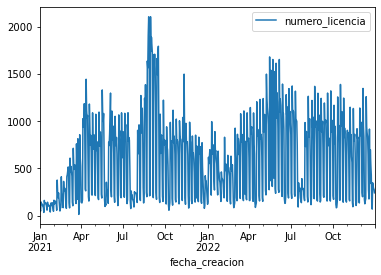

In [18]:
df.groupby('fecha_creacion')[['numero_licencia']].count().plot()

<AxesSubplot:xlabel='mes_anio_creacion'>

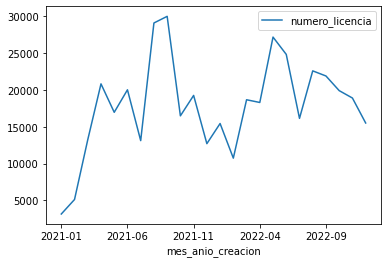

In [19]:
df.groupby('mes_anio_creacion')[['numero_licencia']].count().plot()

# Busqueda de clusters

## Preparacion del dataset y escalado de datos

Los datos deben estar estructurados de forma tal que cada columna corresponda a una determinada serie temporal de la categoria que queremos analizar y observar si existen grupos que se comportan de forma similar.

In [20]:
df_train = pd.pivot_table(df_cluster.reset_index()[['mes_anio_creacion','categoria_diagnostico','numero_licencia']], values='numero_licencia', index='mes_anio_creacion', columns='categoria_diagnostico', aggfunc=np.sum, fill_value=0)

In [21]:
df_train

categoria_diagnostico,ALERGIAS Y ENFERMEDADES AUTOINMUNES,APARATO RESPIRATORIO,BENIGNOS,CARDIOLOGIA,CARDIOVASCULAR,CAUSAS EXTREMAS DE MORBILIDAD Y DE MORTALIDAD,CEREBRO Y NEUROLOGIA,CIRUGIA,Ciertas enfermedades infecciosas y parasitarias,Covid,...,RIÑON Y VIAS URINARIAS,SALUD MENTAL,SANGRE Y GANGLIOS,SECUELAS DE INFARTO CEREBRAL,SIN DEFINICION,SINTOMAS Y SIGNOS,SISTEMA NERVIOSO,TRASTORNOS VASCULARES,TRAUMATISMOS,TRAUMATOLOGIA Y ORTOPEDIA
mes_anio_creacion,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,0,0,0,0,0,0,0,0,514,...,0,1,0,0,0,1,0,0,1,1
2021-02-01,0,0,0,0,0,0,0,0,0,973,...,0,0,0,0,1,0,0,0,0,2
2021-03-01,0,0,0,0,0,0,0,0,0,6830,...,0,2,0,0,0,2,0,0,1,10
2021-04-01,0,1,0,0,0,1,0,0,0,13649,...,0,4,0,0,0,0,0,0,0,7
2021-05-01,0,1,0,2,0,0,0,2,0,9580,...,0,2,0,0,0,2,0,0,0,7
2021-06-01,0,3,0,1,0,3,0,3,0,8659,...,0,3,0,0,0,3,0,0,0,12
2021-07-01,0,0,0,0,0,0,0,3,0,5557,...,0,2,0,0,1,4,0,0,3,14
2021-08-01,0,2,0,1,1,3,0,12,0,15868,...,0,3,0,0,2,1,1,0,8,29
2021-09-01,0,11,1,2,7,12,0,24,0,14887,...,0,13,3,0,5,11,1,2,20,59


Los datos deben ser escalados para poder procesarlos.

In [22]:
scaler = StandardScaler()

In [23]:
X_train = StandardScaler().fit_transform(df_train)
X_train = X_train.T

In [24]:
X_train.shape

(44, 24)

## Eleccion adecuada del numero de cluster

Utilizaremos dos formas para elegir el numero optimo de clusters, para cada una de las distancias a utilizar. Por un lado el metodo del codo y por otro lado la silueta.

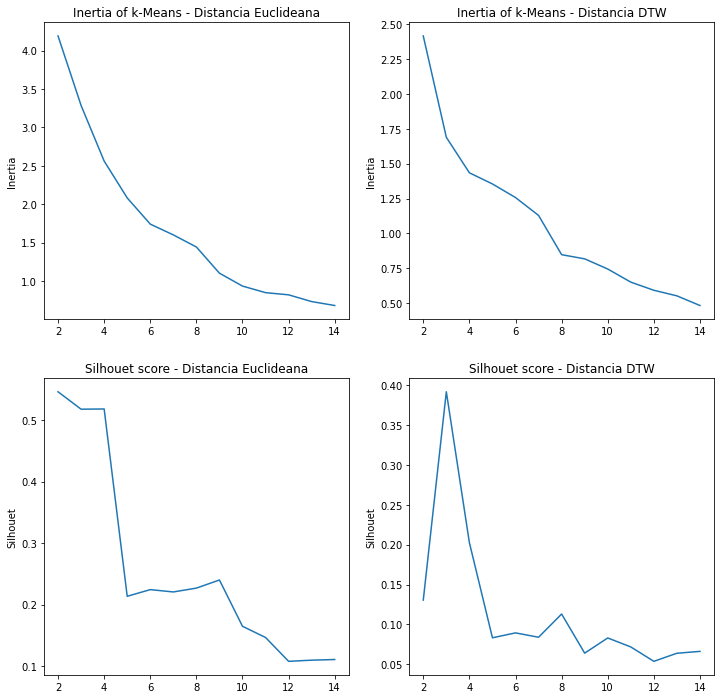

In [25]:
inertia_eu = []
silhouet_eu = []
    
for n in range(2, 15):
    km = TimeSeriesKMeans(n_clusters=n, random_state=42,
                              metric='euclidean').fit(X_train) 
    inertia_eu.append(km.inertia_)
    silhouet_eu.append(silhouette_score(X_train, km.labels_,  metric='euclidean'))

    inertia_dtw = []
    silhouet_dtw = []
    
for n in range(2, 15):
    km = TimeSeriesKMeans(n_clusters=n, random_state=42,
                              metric='dtw').fit(X_train) 
    inertia_dtw.append(km.inertia_)
    silhouet_dtw.append(silhouette_score(X_train, km.labels_,  metric='euclidean'))
      
fig, axes = plt.subplots(2,2,figsize=(12,12))

axes[0,0].plot(np.arange(2, 15), inertia_eu)
axes[0,0].set_ylabel("Inertia")
axes[0,0].set_title("Inertia of k-Means - Distancia Euclideana")

axes[0,1].plot(np.arange(2, 15), inertia_dtw)
axes[0,1].set_ylabel("Inertia")
axes[0,1].set_title("Inertia of k-Means - Distancia DTW")

axes[1,0].plot(np.arange(2, 15), silhouet_eu)
axes[1,0].set_ylabel("Silhouet")
axes[1,0].set_title("Silhouet score - Distancia Euclideana")

axes[1,1].plot(np.arange(2, 15), silhouet_dtw)
axes[1,1].set_ylabel("Silhouet")
axes[1,1].set_title("Silhouet score - Distancia DTW") 

plt.show()

En ambos casos se observa un codo para el numero de cluster 4 y a su vez coincide con el maximo valor de la silhouet score.

## Clustering 

Realizamos el entrenamiento del clusterizador y los graficos para cada uno de los clusters encontrados.

In [26]:
num_eu = 4
num_dtw = 4

num_models = 2
sz = X_train.shape[1]
seed = 42

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=num_eu, random_state=seed)
y_pred_euc = km.fit_predict(X_train)

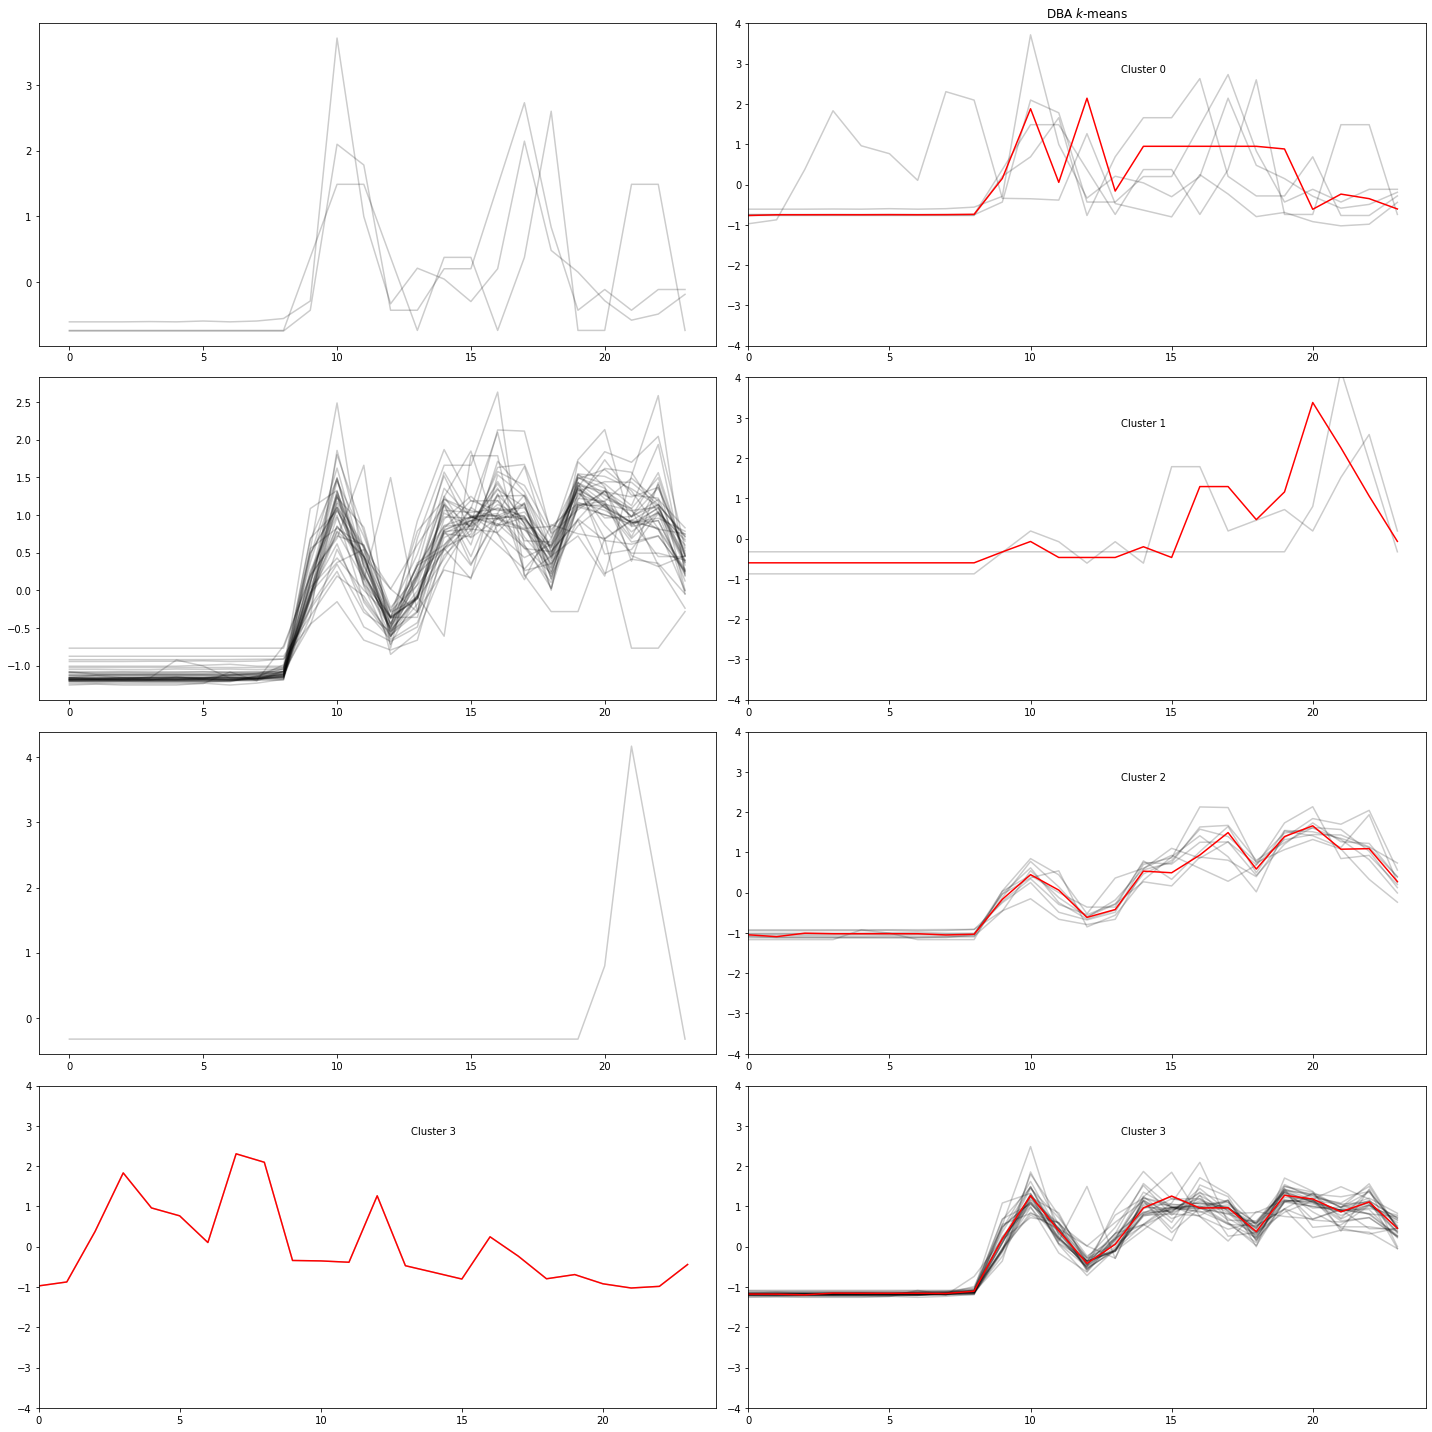

In [27]:
fig = plt.figure(figsize=(20,20))

for yi in range(num_eu):
    plt.subplot(num_eu, num_models, yi*num_models+1)
    for xx in X_train[y_pred_euc == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(km.cluster_centers_[yi].ravel(), "r-")
plt.xlim(0, sz)
plt.ylim(-4, 4)
plt.text(0.55, 0.85,'Cluster %d' % (yi),
         transform=plt.gca().transAxes)
if yi == 0:
        plt.title("Euclidean $k$-means")
        
#DBA-k-means
dba_km = TimeSeriesKMeans(n_clusters=num_dtw,
                          metric="dtw", random_state=seed)
y_pred_dtw = dba_km.fit_predict(X_train)

for yi in range(num_dtw):
    plt.subplot(num_dtw, num_models, yi*num_models+2)
    for xx in X_train[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")

plt.tight_layout()
plt.show()

## Recuperacion de las etiquetas

In [28]:
df_km = pd.DataFrame({'categoria_diagnostico':df_train.T.index.values, 'clust_ts_kmeuc':y_pred_euc, 'clust_ts_kmdtw':y_pred_dtw})

In [29]:
df_km['clust_ts_kmeuc'].value_counts()

1    39
0     3
3     1
2     1
Name: clust_ts_kmeuc, dtype: int64

In [30]:
df_km['clust_ts_kmdtw'].value_counts()

3    28
2     9
0     5
1     2
Name: clust_ts_kmdtw, dtype: int64

In [31]:
df_cluster = df_cluster.merge(df_km, on='categoria_diagnostico')

In [32]:
df_cluster.head()

,mes_anio_creacion,categoria_diagnostico,numero_licencia,clust_ts_kmeuc,clust_ts_kmdtw
0,2021-01-01,Covid,514,3,0
1,2021-02-01,Covid,973,3,0
2,2021-03-01,Covid,6830,3,0
3,2021-04-01,Covid,13649,3,0
4,2021-05-01,Covid,9580,3,0


In [33]:
df_cluster[df_cluster['categoria_diagnostico'] == 'Covid'][['clust_ts_kmeuc','clust_ts_kmdtw']].head(1)

,clust_ts_kmeuc,clust_ts_kmdtw
0,3,0


## Evaluacion de clusters encontrados

Evaluamos si los clusters encontrados son buenos mediante la correlacion.

In [34]:
#Cantidad de sujetos y correlacion promedio de cada uno de los cluster 
for i in np.sort(df_cluster['clust_ts_kmeuc'].unique()):
    print('Cluster Euclideana {} tiene {} sujetos y una correlación promedio de {}'.format(i,df_cluster[df_cluster['clust_ts_kmeuc'] == i]['categoria_diagnostico'].nunique(),
                                                                                           (pd.pivot_table(df_cluster[df_cluster['clust_ts_kmeuc'] == i].reset_index()[['mes_anio_creacion','categoria_diagnostico', 'numero_licencia']],
                                                                                                           values='numero_licencia', index='mes_anio_creacion', columns='categoria_diagnostico',aggfunc=np.sum)).corr().mean().mean()))
print('-'*95)
for i in np.sort(df_cluster['clust_ts_kmdtw'].unique()):
    print('Cluster DTW {}'.format(i) + ' '*(len('Euclideana') - len('DTW')+1)+ 'tiene {} sujetos y una correlación promedio de {}'.format(df_cluster[df_cluster['clust_ts_kmdtw'] == i]['categoria_diagnostico'].nunique(),
                                                                                           (pd.pivot_table(df_cluster[df_cluster['clust_ts_kmdtw'] == i].reset_index()[['mes_anio_creacion','categoria_diagnostico',  'numero_licencia']],
                                                                                                           values='numero_licencia', index='mes_anio_creacion', columns='categoria_diagnostico',aggfunc=np.sum)).corr().mean().mean()))
print('-'*95)

Cluster Euclideana 0 tiene 3 sujetos y una correlación promedio de 0.5838744729517898
Cluster Euclideana 1 tiene 39 sujetos y una correlación promedio de 0.7535776719262881
Cluster Euclideana 2 tiene 1 sujetos y una correlación promedio de 1.0
Cluster Euclideana 3 tiene 1 sujetos y una correlación promedio de 1.0
-----------------------------------------------------------------------------------------------
Cluster DTW 0        tiene 5 sujetos y una correlación promedio de 0.2625464502901872
Cluster DTW 1        tiene 2 sujetos y una correlación promedio de 0.6935735673983309
Cluster DTW 2        tiene 9 sujetos y una correlación promedio de 0.8700828601955014
Cluster DTW 3        tiene 28 sujetos y una correlación promedio de 0.8321903491463595
-----------------------------------------------------------------------------------------------


Tambien podemos observar el comportamiento de las series temporales que conforman un determinado clusters. 

In [35]:
diag = list(df_cluster[df_cluster['clust_ts_kmdtw'] == 2].categoria_diagnostico.unique())

<AxesSubplot:xlabel='mes_anio_creacion'>

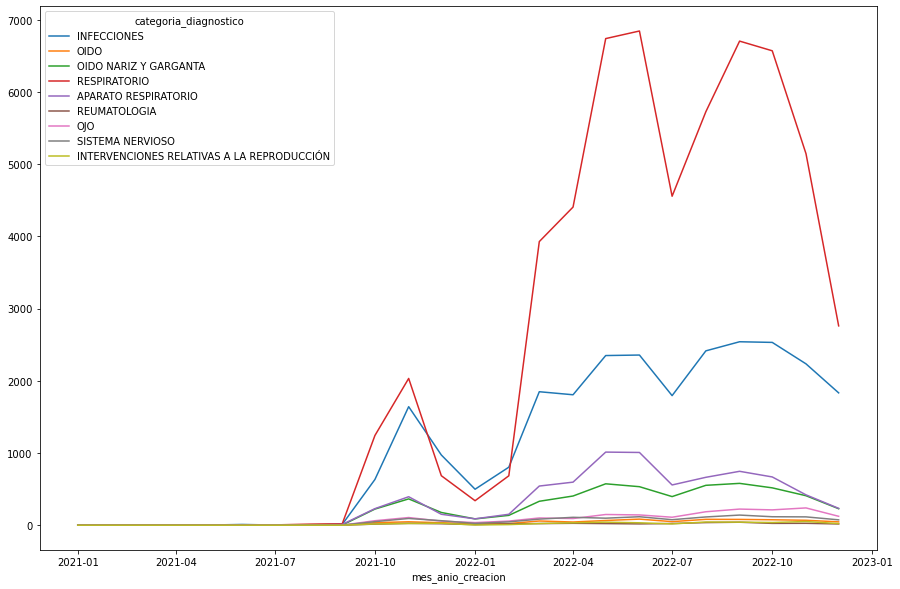

In [36]:
df_train[diag].plot(figsize=(15,10))